In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
import requests
from io import BytesIO

In [ ]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media

     |████████████████████████████████| 1.6 MB 42.8 MB/s 


# References



1.   Growing Neural Cellular Automata :  [paper] https://distill.pub/2020/growing-ca/ [code demo] https://www.youtube.com/watch?v=kA7_LGjen7o
2.   Learning to Simulate Complex Physics with Graph Networks : [paper] https://cs.stanford.edu/people/jure/pubs/learning_to_simulate-icml20.pdf  [presentation] https://icml.cc/virtual/2020/poster/6849
3.   ...



# Constants

# UTILS

In [ ]:
def grayscale_m(x):
    return x[0,:,:,0]

def rg_m(x):
    return x[0,:,:,:2]

def rgb_m(x):
    return x[0,:,:,:3]

def mask(x, n_chan):
    return x[0,:,:,:n_chan]

def plot(x):
    plt.imshow(grayscale_m(x), cmap='Greys')
    plt.show()

def save_plot(x, filename):
    plt.imshow(grayscale_m(x), cmap='Greys')
    plt.savefig(str(filename) + '.png')

def mask_edges(x):
  x[0,0,:,0] = np.zeros(64)
  x[0,:,0,0] = np.zeros(64)
  x[0,:,63,0] = np.zeros(64)
  x[0,63,:,0] = np.zeros(64)
  return x

def get_living_mask(x , alpha = 0.01 ,  n_chan = 1):
    if n_chan == 1:
      channel_alpha = x[:, :, :, 0]
    elif n_chan == 2:
      channel_alpha = x[:, :, :, 0] + x[:, :, :, 1]
    #return tf.nn.max_pool2d(channel_alpha, 3, [1, 1, 1, 1], 'SAME') > alpha
    return np.expand_dims(channel_alpha > alpha, axis=-1)

def modelToGif(model , start_frame , steps, channels=1, mask=False, fps = 8, hiddenc = True , emb = None):
  _, n, m, _ = tf.shape(start_frame)
  x = start_frame
  #print(tf.reduce_sum(x[:,:,:,0]))
  main_channel = []
  hidden_channel = []
  for i in range(steps):
      if channels == 3 : 
        main_channel.append(np.absolute(x.numpy()[0,:,:,:3]))
        if hiddenc :
          hidden_channel.append(np.absolute(x.numpy()[0,:,:,3:6]))
      elif channels == 2: 
        main_channel.append(np.concatenate([x.numpy()[0,:,:,:2]*10, np.zeros((n,m,1))], axis=2))
        if hiddenc :
          hidden_channel.append(x.numpy()[0,:,:,2:5])
      else:
        main_channel.append(x.numpy()[0,:,:,0])
        if hiddenc :
          hidden_channel.append(x.numpy()[0,:,:,1:4])
      if emb is None:
        x = model(x , mask=mask)
      else:
        x_emb = tf.concat([tf.cast(x,tf.float32) , tf.cast(emb,tf.float32)],-1)
        x = model( x_emb , x , mask= mask)

      #print(tf.reduce_sum(x[:,:,:,0]))
        
  videos = {
    'main channel': main_channel,
    'hidden channel': hidden_channel,
  }  
  if not hiddenc:
    videos = {
    'main channel': main_channel,
    }

  media.show_videos(videos, height=160, fps=fps, codec='gif', border=True)
  return videos

def datasetToFrames(ds):
  video = []
  _, n, m, c = np.shape(ds[0])
  print(n, n, c)
  for i in ds:
    if c == 1:
      video.append(i[0,:,:,0])
      #video.append(np.concatenate([i[0], i[0], i[0]], axis=2))
    elif c == 2:
      video.append(np.concatenate([i[0], np.zeros((n,m,1))], axis=2))
    else:
      video.append(i[0])
  return video

def toGif(frames):
  media.show_video(frames, height=160, fps=24, codec='gif', border=True)

# Falling Square

64 64 1



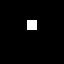

In [ ]:
#@title Dataset { vertical-output: true}
def getFallingSquareDS():
  dataset = []
  for i in range(60):
    base = np.zeros((1,64,64,1))
    length = 10
    idx , idy = 20,27
    idx += i
    base[:,idx:idx+length,idy:idy+length] = np.ones(1)
    dataset.append(base)
  return dataset

dsSquareFall = getFallingSquareDS()
toGif(datasetToFrames(dsSquareFall))

In [ ]:
#@title Model { vertical-output: true}
class NNA(tf.keras.Model):

    def __init__(self, n_channels):
        super().__init__()
        self.channel_n = n_channels
        self.alpha = alpha

        self.dmodel = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 1, activation=tf.nn.relu),
            tf.keras.layers.Conv2D(self.channel_n, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        self(tf.zeros([1, 3, 3, n_channels]))

    def perceive(self, x):
        cellID = tf.constant([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]], dtype=tf.float32)
        sobelX = tf.constant([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=tf.float32)
        sobelY = tf.constant([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=tf.float32)

        kernel = tf.stack([cellID, sobelX, sobelY], -1)[:, :, None, :]
        kernel = tf.repeat(kernel, self.channel_n, 2)

        y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
        return y

    def call(self, x, steps = 1 , mask = False):
        if mask:
          pre_live_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y) * steps

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= 0.5
        x += dx * tf.cast(update_mask, tf.float32)

        if mask:
          post_life_mask = get_living_mask(x)
          life_mask = pre_live_mask | post_life_mask
          life_mask = mask_edges(life_mask)
          return x * tf.cast(life_mask, tf.float32)

        return x

model = NNA(4)
model.summary()

Model: "nna_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_27 (Sequential)  (1, 3, 3, 4)              2180      
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000], [lr, lr*0.05])
optimizer = tf.keras.optimizers.Adam(lr_sched)
loss_object = tf.keras.losses.MeanSquaredError()

Epoch 0 , Loss 194.091796875



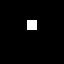
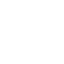

Epoch 100 , Loss 54.74336624145508



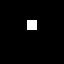
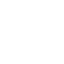

KeyboardInterrupt: ignored

In [ ]:
n_channels = 1
n_hidden_channels = 3
model = NNA(n_channels + n_hidden_channels)
dataset = dsSquareFall

start_frame = 0
end_frame = 50

init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,64,64,hidden_channels))) , axis = -1))

#@title Loss frame by frame { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    loss = 0
    x = init
    with tf.GradientTape() as g:        
        for i in tf.range(start_frame, end_frame):
              x = model(x)
              loss += loss_object(grayscale_m(dataset[i+1]), grayscale_m(x)) * 100
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init ,50)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

In [ ]:
n_channels = 1
n_hidden_channels = 3
extra_steps = 10
model = NNA(n_channels + n_hidden_channels)
dataset = dsSquareFall

start_frame = 0

init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,64,64,hidden_channels))) , axis = -1))

#@title Loss frame + 10 extra steps { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    loss = 0
    extra_step = 10
    x = init
    with tf.GradientTape() as g:        
        for i in tf.range(start_frame, 10):
              for j in range(extra_step):
                  x = model(x)
              loss += loss_object(grayscale_m(dataset[i+1]), grayscale_m(x)) * 100
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init ,500)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Epoch 0 , Loss 26.85546875



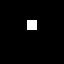
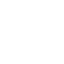

Epoch 100 , Loss 2.35192608833313



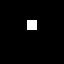
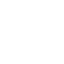

KeyboardInterrupt: ignored

In [ ]:
n_channels = 1
n_hidden_channels = 3
extra_steps = 10
start_frame = 0
end_frame = 10
model = NNA(n_channels + n_hidden_channels)
dataset = dsSquareFall

init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,64,64,hidden_channels))) , axis = -1))

#@title Loss frame + masking + 10 extra steps { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    loss = 0
    extra_step = 10
    x = init
    with tf.GradientTape() as g:        
        for i in tf.range(start_frame, end_frame):
              for j in range(extra_step):
                  x = model(x , mask=True)
              loss += loss_object(grayscale_m(dataset[i+1]), grayscale_m(x)) * 100
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss
EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init , 500 , mask=True)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

Epoch 0 , Loss 26.85546875



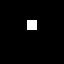

KeyboardInterrupt: ignored

In [ ]:
n_channels = 1
n_hidden_channels = 0
extra_steps = 10
start_frame = 0
end_frame = 10
model = NNA(n_channels + n_hidden_channels)
dataset = dsSquareFall

init = tf.convert_to_tensor(dataset[start_frame])

#@title Loss frame + masking + 10 extra steps + no hidden channels { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    loss = 0
    extra_step = 10
    x = init
    with tf.GradientTape() as g:        
        for i in tf.range(start_frame, end_frame):
              for j in range(extra_step):
                  x = model(x , mask=True)
              loss += loss_object(grayscale_m(dataset[i+1]), grayscale_m(x)) * 100
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init , 500 , mask=True, hiddenc=False)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

# Fluid Sim

64 64 1



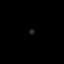

64 64 3



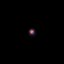

In [ ]:
urlPrefix = 'https://raw.githubusercontent.com/andrinr/dlca-simulation/main/data/'
#@title Dataset { vertical-output: true}

def getDyeDS():
  dataset = []
  for i in range(150):
    filename = f'export/frame_dye_{i:05d}.png'
    r = requests.get(urlPrefix+filename, stream=True)
    img = tf.keras.preprocessing.image.load_img(BytesIO(r.content), color_mode='grayscale', target_size=(64, 64))
    img = np.expand_dims(np.array(img), axis=2)
    img = tf.expand_dims(img, 0) / 255
    dataset.append(img.numpy())
  return dataset

def getDye2DS():
  dataset = []
  for i in range(150):
    filename = f'export3/frame_dye_{i:05d}.png'
    r = requests.get(urlPrefix+filename, stream=True)
    img = tf.keras.preprocessing.image.load_img(BytesIO(r.content), color_mode='rgb', target_size=(64, 64))
    img = tf.expand_dims(np.array(img), 0) / 255
    dataset.append(img.numpy())
  return dataset

def getCurlDS():
  dataset = []
  for i in range(200):
    filename = f'export/frame_curl_{i:05d}.png'
    r = requests.get(urlPrefix+filename, stream=True)
    img = tf.keras.preprocessing.image.load_img(BytesIO(r.content), color_mode='grayscale', target_size=(64, 64))
    img = np.expand_dims(np.array(img), axis=2)
    img = tf.expand_dims(np.array(img), 0) /255
    dataset.append(img.numpy())
  return dataset

def getVelDS():
  dataset = []
  for i in range(200):
    filename = f'frame_vel_{i:05d}.png'
    r = requests.get(urlPrefix+filename, stream=True)
    img = tf.keras.preprocessing.image.load_img(BytesIO(r.content), color_mode='rgb', target_size=(64, 64))
    img = np.array(img)
    img = tf.expand_dims(img, 0) / 255
    dataset.append(img.numpy()[:,:,:,:2])
  return dataset

dsDye = getDyeDS()
toGif(datasetToFrames(dsDye))\

dsDye2 = getDye2DS()
toGif(datasetToFrames(dsDye2))

#dsCurl = getCurlDS()
#dsVel = getVelDS()
#toGif(datasetToFrames(dsVel))

(150, 1, 64, 64, 3)
64 64 3



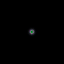

64 64 1



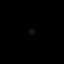

In [ ]:
#@title Dataset Difference { vertical-output: true}
print(np.shape(dsDye2))
def getDifference(inDataset):
  _, _, _, _, c = tf.shape(inDataset)
  dataset = []
  for i in range(len(inDataset)-1):
    frame = np.zeros((1, 64, 64, c))
    for j in range(c):
      #frame[0, :, :, 0] = inDataset[i+1][ 0, : , : , 0]
      frame[0, :, :, j] = inDataset[i+1][ 0, : , : , j] - inDataset[i][0,  : , : , j]
    dataset.append(frame)

  return dataset

dsDye2Diff = getDifference(dsDye2)
toGif(datasetToFrames(dsDye2Diff))


dsDyeDiff = getDifference(dsDye)
toGif(datasetToFrames(dsDyeDiff))

In [ ]:
#@title Dataset Masked velocity { vertical-output: true}
print(np.shape(dsDye))
def getDifference(velocity, dye):
  dataset = []
  for i in range(len(velocity)-1):
    frame = velocity
    get_living_mask(dye)
    frame[dye[i] < alpha] = 0
    
    dataset.append(frame)

  return dataset

dsVelMask = getDifference(dsVel, dsDye)
toGif(datasetToFrames(dsVelMask))

In [ ]:
#@title Model { vertical-output: true}
class NNA(tf.keras.Model):

    def __init__(self, n_channels):
        super().__init__()
        self.channel_n = n_channels
        self.alpha = alpha

        self.dmodel = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 1, activation=tf.nn.relu),
            tf.keras.layers.Conv2D(self.channel_n, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        self(tf.zeros([1, 3, 3, n_channels]))

    def perceive(self, x):
        cellID = tf.constant([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]], dtype=tf.float32)
        sobelX = tf.constant([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=tf.float32)
        sobelY = tf.constant([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=tf.float32)

        kernel = tf.stack([cellID, sobelX, sobelY], -1)[:, :, None, :]
        kernel = tf.repeat(kernel, self.channel_n, 2)

        y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
        return y

    def call(self, x, steps = 1 , mask = False):
        if mask:
          pre_live_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y) * steps

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= 0.5
        x += dx * tf.cast(update_mask, tf.float32)

        if mask:
          post_life_mask = get_living_mask(x)
          life_mask = pre_live_mask | post_life_mask
          life_mask = mask_edges(life_mask)
          return x * tf.cast(life_mask, tf.float32)

        return x

model = NNA(4)
model.summary()

NameError: ignored

In [ ]:
lr = 2e-03
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000], [lr, lr*0.05])
optimizer = tf.keras.optimizers.Adam(lr_sched)
loss_object = tf.keras.losses.MeanSquaredError()

Epoch 0 , Loss 30.45166015625



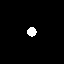
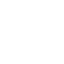

Epoch 100 , Loss 27.75469970703125



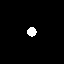
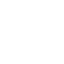

KeyboardInterrupt: ignored

In [ ]:
n_channels = 1
n_hidden_channels = 3
extra_steps = 10
start_frame = 0
end_frame = 40
max_frame_steps = 10
model = NNA(n_channels + n_hidden_channels)
dataset = dsDye

init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,64,64,hidden_channels))) , axis = -1))

#@title Dye : Loss frame + mask + rand init frame + extra steps { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    frame_steps = tf.random.uniform([],1,max_frame_steps,tf.int32)
    loss = 0
    random_frame_idx = np.random.randint(start_frame,end_frame-max_frame_steps)
    x = tf.convert_to_tensor(np.concatenate((dataset[random_frame_idx],np.ones((1,64,64,hidden_channels))) , axis = -1))
    with tf.GradientTape() as g:        
        for i in tf.range(frame_steps):
          for j in tf.range(extra_steps):
              x = model(x , mask= True)
        loss += loss_object(grayscale_m(dataset[random_frame_idx+frame_steps]), grayscale_m(x))
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init ,500 , fps=40, mask= True)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

Epoch 0 , Loss 1491.29638671875



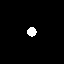
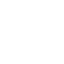

Epoch 100 , Loss 1112.954833984375



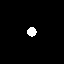
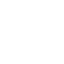

KeyboardInterrupt: ignored

In [ ]:
n_channels = 1
n_hidden_channels = 3
extra_steps = 10
start_frame = 0
end_frame = 40
max_frame_steps = 10
model = NNA(n_channels + n_hidden_channels)

dataset = dsDye
alpha = 0.1

init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,64,64,hidden_channels))) , axis = -1))

#@title Dye : Loss frame + mask + rand init frame + extra steps + all sim per epoch { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    loss = 0
    interval = 5
    frame_idx = 0
    for loopel in range(end_frame//interval):
      x = tf.convert_to_tensor(np.concatenate((dataset[frame_idx],np.ones((1,64,64,hidden_channels))) , axis = -1))
      with tf.GradientTape() as g:        
          for i in tf.range(interval):
            for j in tf.range(extra_steps):
                x = model(x , mask= True)
          #plot(dataset[frame_idx])
          #plot(x)
          #plot(dataset[frame_idx+interval])
          #print(f'frame idx: {frame_idx}' )
          loss += loss_object(grayscale_m(dataset[frame_idx+interval]), grayscale_m(x))
      frame_idx += interval
    
    
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif( model , init , 500 , fps=40 ,  mask= True )

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

In [ ]:
n_channels = 1
n_hidden_channels = 3
extra_steps = 30
start_frame = 0
end_frame = 40
max_frame_steps = 5
model = NNA(n_channels + n_hidden_channels)

init = tf.convert_to_tensor(np.concatenate((dsVel[start_frame] , dsCurl[start_frame] ,np.ones((1,64,64,hidden_channels))) , axis = -1))

#@title Vel : Loss frame + rand init frame + 30 extra steps { vertical-output: true}
def train_step_frame_at_a_time():
    frame_steps = tf.random.uniform([],1,max_frame_steps,tf.int32)
    loss = 0
    random_frame_idx = np.random.randint(start_frame,end_frame-max_frame_steps)
    x = tf.convert_to_tensor(np.concatenate((dsVel[start_frame] , dsCurl[start_frame],np.ones((1,64,64,hidden_channels))) , axis = -1))
    with tf.GradientTape() as g:        
        for i in tf.range(frame_steps):
          for j in tf.range(extra_steps):
              x = model(x)
        loss += loss_object(np.concatenate((dsVel[random_frame_idx+frame_steps] , dsCurl[random_frame_idx+frame_steps]) , axis = -1), rgb_m(x)) * 100
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      _ = modelToGif(model, init ,500 , channels=3)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Epoch 0 , Loss 53.734397888183594



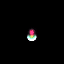
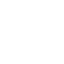

Epoch 100 , Loss 37.18621063232422



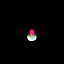
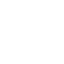

Epoch 200 , Loss 8.468679428100586



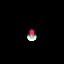
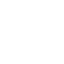

Epoch 300 , Loss 12.484615325927734



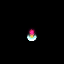
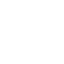

KeyboardInterrupt: ignored

In [ ]:
n_channels = 3
n_hidden_channels = 6
extra_steps = 10
start_frame = 10
end_frame = 100
max_frame_steps = 20
alpha = 0.01
model = NNA(n_channels + n_hidden_channels)

dataset = dsDye2
init = tf.convert_to_tensor(np.concatenate((dataset[start_frame] ,np.ones((1,64,64,n_hidden_channels))) , axis = -1))

#@title Dye2 : Loss frame + rand init frame + 30 extra steps { vertical-output: true}
def train_step_frame_at_a_time():
    frame_steps = tf.random.uniform([],1,max_frame_steps,tf.int32)
    loss = 0
    random_frame_idx = np.random.randint(start_frame,end_frame-max_frame_steps)
    x = tf.convert_to_tensor(np.concatenate((dataset[start_frame] ,np.ones((1,64,64,n_hidden_channels))) , axis = -1))
    with tf.GradientTape() as g:        
        for i in tf.range(frame_steps):
          for j in tf.range(extra_steps):
              x = model(x)
          loss += loss_object(dataset[random_frame_idx+frame_steps], rgb_m(x)) * 100
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      _ = modelToGif(model, init ,100 , channels=3)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

In [ ]:
#@title Model { vertical-output: true}
class NNA(tf.keras.Model):

    def __init__(self, n_channels):
        super().__init__()
        self.channel_n = n_channels
        self.alpha = alpha

        self.dmodel = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu, padding='same'),
            tf.keras.layers.Conv2D(32, 2, activation=tf.nn.relu, padding='same'),
            tf.keras.layers.Conv2D(32, 1, activation=tf.nn.relu, padding='same'),
            tf.keras.layers.Conv2D(self.channel_n, 1, padding='same', activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        self(tf.zeros([1, 3, 3, n_channels]))

    def perceive(self, x):
        cellID = tf.constant([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]], dtype=tf.float32)
        sobelX = tf.constant([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=tf.float32)
        sobelY = tf.constant([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=tf.float32)

        kernel = tf.stack([cellID, sobelX, sobelY], -1)[:, :, None, :]
        kernel = tf.repeat(kernel, self.channel_n, 2)

        y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
        return y

    def call(self, x, steps = 1 , mask = False):
        if mask:
          pre_live_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y) * steps

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= 0.5
        x += dx * tf.cast(update_mask, tf.float32)

        if mask:
          post_life_mask = get_living_mask(x)
          life_mask = pre_live_mask | post_life_mask
          life_mask = mask_edges(life_mask)
          return x * tf.cast(life_mask, tf.float32)

        return x

model = NNA(4)
model.summary()

Model: "nna_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (1, 3, 3, 4)              8804      
                                                                 
Total params: 8,804
Trainable params: 8,804
Non-trainable params: 0
_________________________________________________________________


Epoch 0 , Loss 0.3813663125038147



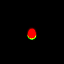
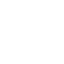

Epoch 100 , Loss 0.2107890397310257



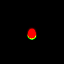
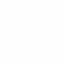

Epoch 200 , Loss 0.18217940628528595



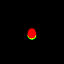
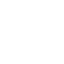

Epoch 300 , Loss 0.1540166437625885



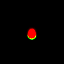
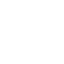

Epoch 400 , Loss 0.06004244089126587



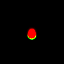
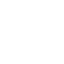

Epoch 500 , Loss 0.034545719623565674



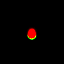
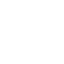

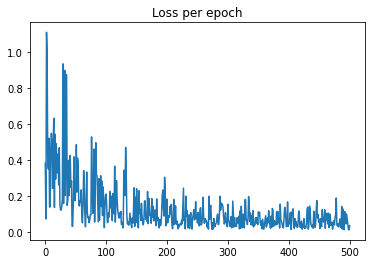

In [ ]:
n_channels = 2
n_hidden_channels = 6
extra_steps = 3
start_frame = 10
end_frame = 50
max_frame_steps = 20
alpha = 0.01
model = NNA(n_channels + n_hidden_channels)

dataset = dsDye
dataset2 = dsDyeDiff
init = tf.convert_to_tensor(np.concatenate((dataset[start_frame], dataset2[start_frame], np.ones((1,64,64,n_hidden_channels))) , axis = -1))

#@title Dye2 : Loss frame + rand init frame + 30 extra steps { vertical-output: true}
def train_step_frame_at_a_time():
    frame_steps = tf.random.uniform([],1,max_frame_steps,tf.int32)
    loss = 0
    random_frame_idx = np.random.randint(start_frame,end_frame-max_frame_steps)
    x = tf.convert_to_tensor(np.concatenate((dataset[start_frame], dataset2[start_frame] ,np.ones((1,64,64,n_hidden_channels))) , axis = -1))
    with tf.GradientTape() as g:        
        for i in tf.range(frame_steps):
          for j in tf.range(extra_steps):
              x = model(x)
          loss += loss_object(np.concatenate((dataset[start_frame + j], dataset2[start_frame + j]), axis=-1), rg_m(x)) * 100
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      _ = modelToGif(model, init ,100 , channels=2)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

## postion embedding

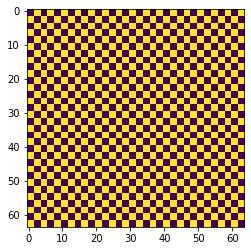

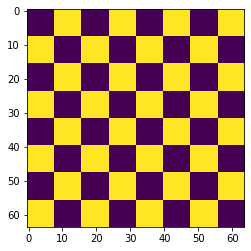

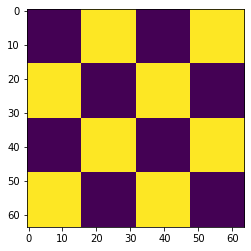

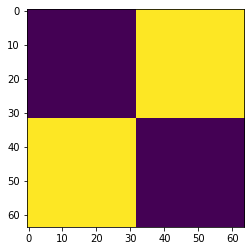

In [ ]:
#@title Position Emb { vertical-output: true}
def getPositionEmb(size):
  c = tf.math.ceil( tf.math.log(float(size)) / tf.math.log(2.0) )
  o = tf.expand_dims( 2**tf.range(c) , 1 )
  a = tf.expand_dims(tf.range(float(size)) , 0)
  pe = tf.math.floordiv( a , o ) % 2
  pe = tf.transpose(pe)
  pe = tf.repeat( [pe] , size , axis=0, name=None )
  pe = pe > 0
  pe = tf.math.logical_xor(pe,  tf.transpose(pe, [1, 0, 2]))
  pe = tf.expand_dims( pe , 0 )
  pe = tf.cast(pe, tf.float32)
  return pe

pe = getPositionEmb(64)

plt.imshow(pe[0,:,:,1])
plt.show()
plt.imshow(pe[0,:,:,3])
plt.show()
plt.imshow(pe[0,:,:,4])
plt.show()
plt.imshow(pe[0,:,:,5])
plt.show()



In [ ]:
#@title Model { vertical-output: true}
class NNA(tf.keras.Model):

    def __init__(self, n_channels_in , n_channels_out):
        super().__init__()
        self.channel_n = n_channels_in
        self.channel_out = n_channels_out

        self.alpha = alpha

        self.dmodel = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 1, activation=tf.nn.relu),
            tf.keras.layers.Conv2D(self.channel_out, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        self(tf.zeros([1, 3, 3, self.channel_n]),tf.zeros([1, 3, 3, self.channel_out]))

    def perceive(self, x):
        cellID = tf.constant([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]], dtype=tf.float32)
        sobelX = tf.constant([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=tf.float32)
        sobelY = tf.constant([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=tf.float32)

        kernel = tf.stack([cellID, sobelX, sobelY], -1)[:, :, None, :]
        kernel = tf.repeat(kernel, self.channel_n, 2)

        y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
        return y

    def call(self, x , x1 , steps = 1 , mask = False):
        x = tf.cast(x ,  tf.float32)
        x1 = tf.cast(x1 ,  tf.float32)
        if mask:
          pre_live_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y) * steps

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= 0.5
        x1 += dx * tf.cast(update_mask, tf.float32)

        if mask:
          post_life_mask = get_living_mask(x1)
          life_mask = pre_live_mask | post_life_mask
          life_mask = mask_edges(life_mask)
          return x1 * tf.cast(life_mask, tf.float32)

        return x1
        
model = NNA(n_channels , n_channels)
model.summary()

Model: "nna_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_41 (Sequential)  (1, 3, 3, 1)              641       
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


Epoch 0 , Loss 401.82958984375



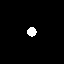
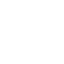

Epoch 100 , Loss 111.22807312011719



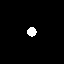
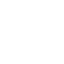

Epoch 200 , Loss 76.22125244140625



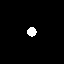
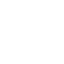

KeyboardInterrupt: ignored

In [ ]:
n_channels = 4
n_hidden_channels = 6
n_embedding_channels = 4
extra_steps = 20
start_frame = 0
end_frame = 40
max_frame_steps = 10

model = NNA(n_channels + n_hidden_channels , n_embedding_channels)
dataset = dsDye

pos_emb = getPositionEmb(64)
init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,64,64,hidden_channels))) , axis = -1))

#@title Dye : Loss frame + rand init frame + 5 extra steps + position encoding { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    frame_steps = tf.random.uniform([],1,max_frame_steps,tf.int32)
    loss = 0
    random_frame_idx = np.random.randint(start_frame,end_frame-max_frame_steps)
    x = tf.cast(tf.convert_to_tensor(np.concatenate((dataset[random_frame_idx],np.ones((1,64,64,hidden_channels))) , axis = -1)),tf.float32)
    with tf.GradientTape() as g:        
        for i in tf.range(frame_steps):
          for j in tf.range(extra_steps):
              x_emb = tf.concat([x , pos_emb],-1)
              x = model( x_emb , x )
        loss += loss_object(grayscale_m(dataset[random_frame_idx+frame_steps]), grayscale_m(x))
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init ,500 , emb = pos_emb)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

In [ ]:
n_channels = 4
n_hidden_channels = 6
n_embedding_channels = 4
extra_steps = 20
start_frame = 0
end_frame = 40
max_frame_steps = 10

model = NNA(n_channels + n_hidden_channels , n_embedding_channels)

dataset = dsDye

alpha= 0.1

start_frame = 0
end_frame = 40
max_frame_steps = 10
extra_steps = 20

pos_emb = getPositionEmb(64)
init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,64,64,hidden_channels))) , axis = -1))

#@title Dye : Loss frame + rand init frame + 20 extra steps + position encoding + mask { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    frame_steps = tf.random.uniform([],1,max_frame_steps,tf.int32)
    loss = 0
    random_frame_idx = np.random.randint(start_frame,end_frame-max_frame_steps)
    x = tf.cast(tf.convert_to_tensor(np.concatenate((dataset[random_frame_idx],np.ones((1,64,64,hidden_channels))) , axis = -1)),tf.float32)
    with tf.GradientTape() as g:        
        for i in tf.range(frame_steps):
          for j in tf.range(extra_steps):
              x_emb = tf.concat([x , pos_emb],-1)
              x = model( x_emb , x , mask=True)
        loss += loss_object(grayscale_m(dataset[random_frame_idx+frame_steps]), grayscale_m(x))
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 500 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init ,500 , emb = pos_emb , fps=25, mask=True)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Epoch 0 , Loss 865.53759765625



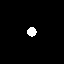
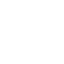

Epoch 250 , Loss 595.4807739257812



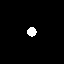
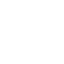

Epoch 500 , Loss 347.4361877441406



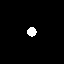
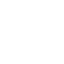

KeyboardInterrupt: ignored

In [ ]:
n_channels = 4
n_hidden_channels = 6
n_embedding_channels = 4
extra_steps = 20
start_frame = 0
end_frame = 40
max_frame_steps = 10

model = NNA(n_channels + n_hidden_channels , n_embedding_channels)
dataset = dsDye

alpha= 0.1


pos_emb = getPositionEmb(64)
init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,64,64,hidden_channels))) , axis = -1))

#@title Dye : Loss frame + rand init frame + 20 extra steps + position encoding + mask { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    loss = 0
    interval = 10
    frame_idx = 0
    for loopel in range(end_frame//interval):
      frame_steps = tf.random.uniform([],3,interval,tf.int32)
      x = tf.cast(tf.convert_to_tensor(np.concatenate((dataset[frame_idx],np.ones((1,64,64,hidden_channels))) , axis = -1)),tf.float32)
      with tf.GradientTape() as g:        
          for i in tf.range(frame_steps):
            for j in tf.range(extra_steps):
                x_emb = tf.concat([x , pos_emb],-1)
                x = model( x_emb , x , mask=True)
          loss += loss_object(grayscale_m(dataset[frame_idx+frame_steps]), grayscale_m(x))
      frame_idx += interval
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init ,500 , emb = pos_emb , fps=25, mask=True)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

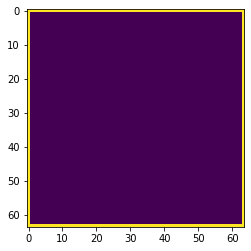

In [ ]:
#@title Border Channel  { vertical-output: true}
def getBorder(size):
  b = np.ones((size,size))
  b = np.expand_dims(b,0)
  b = np.expand_dims(b,3)
  b[0,1:-1,1:-1,0] = 0
  b = tf.convert_to_tensor(b)
  b = tf.cast(b, tf.float32)
  return b

pe = getBorder(64)

plt.imshow(pe[0,:,:,0])
plt.show()

In [ ]:
#@title Position Absolute Encoding  { vertical-output: true}
def getPositionEmb2(size):
  l = np.linspace(0, 1, num=size)
  pe_x = np.repeat(l, size, 0)
  pe_x = np.reshape(pe_x, (size, size))
  pe_y = pe_x.T

  pe = np.zeros((1,size,size,2))
  pe[0,:,:,0] = pe_x
  pe[0,:,:,1] = pe_y

  pe = tf.convert_to_tensor(pe)
  pe = tf.cast(pe, tf.float32)

  return tf.convert_to_tensor(pe)

pe = getPositionEmb2(64)

plt.imshow(pe[0,:,:,0])
plt.show()
plt.imshow(pe[0,:,:,1])
plt.show()

In [ ]:
n_channels = 4
n_hidden_channels = 6
n_embedding_channels = 4
extra_steps = 20
start_frame = 0
end_frame = 90
max_frame_steps = 10

model = NNA(n_channels + n_hidden_channels , n_embedding_channels)

dataset = dsDye

alpha= 0.1

pos_emb = getPositionEmb2(64)
init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,64,64,hidden_channels))) , axis = -1))

#@title Dye : Loss frame + rand init frame + 20 extra steps + absolute position encoding + mask { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    frame_steps = tf.random.uniform([],1,max_frame_steps,tf.int32)
    loss = 0
    random_frame_idx = np.random.randint(start_frame,end_frame-max_frame_steps)
    x = tf.cast(tf.convert_to_tensor(np.concatenate((dataset[random_frame_idx],np.ones((1,64,64,hidden_channels))) , axis = -1)),tf.float32)
    with tf.GradientTape() as g:        
        for i in tf.range(frame_steps):
          for j in tf.range(extra_steps):
              x_emb = tf.concat([x , pos_emb],-1)
              x = model( x_emb , x , mask=True)
        loss += loss_object(grayscale_m(dataset[random_frame_idx+frame_steps]), grayscale_m(x))
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 3000
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init ,100 , emb = pos_emb , fps=18, mask=True)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

NameError: ignored

## Noise

In [ ]:
def add_noise(dataset, frameID, level = 0.1):
  _, _, _, c = np.shape(dataset[0])
  noise = np.random.random((64, 64, c)) * 255 * level
  noise = np.expand_dims(noise, 0)
  channels = np.concatenate((dataset[frameID] + noise ,np.ones((1,64,64,hidden_channels))), axis = -1)
  x = tf.cast(tf.convert_to_tensor(channels),tf.float32)
  return x

plt.imshow(add_noise(dsDyeDiff, 20, 0.2)[0,:,:,0])

plt.imshow(add_noise(dsDyeDiff, 20, 0.2)[0,:,:,1])

In [ ]:
n_channels = 4
n_hidden_channels = 6
n_embedding_channels = 4
extra_steps = 10
start_frame = 0
end_frame = 90
max_frame_steps = 10

model = NNA(n_channels + n_hidden_channels , n_embedding_channels)
dataset = dsDye

alpha= 0.1

pos_emb = getPositionEmb2(64)
border = getBorder(64)
print(tf.shape(border))
init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,64,64,hidden_channels))) , axis = -1))

#@title Dye : Loss frame + rand init frame + 10 extra steps + absolute position encoding + noise + mask { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    frame_steps = tf.random.uniform([],1,max_frame_steps,tf.int32)
    loss = 0
    random_frame_idx = np.random.randint(start_frame,end_frame-max_frame_steps)
    x = add_noise(dataset, random_frame_idx) 
    with tf.GradientTape() as g:        
        for i in tf.range(frame_steps):
          for j in tf.range(extra_steps):
              x_emb = tf.concat([x , pos_emb, border],-1)
              x = model( x_emb , x , mask=True)
        loss += loss_object(grayscale_m(dataset[random_frame_idx+frame_steps]), grayscale_m(x))
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 1000
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 50 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init ,500 , emb = pos_emb , fps=18, mask=True)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

In [ ]:
n_channels = 2 + hidden_channels
model = NNA(n_channels + 2 , n_channels)
dataset = dsVel

alpha= 0.1

start_frame = 20
end_frame = 200
max_frame_steps = 10
extra_steps = 10

pos_emb = getPositionEmb2(64)
border = getBorder(64)
print(tf.shape(border))
init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,64,64,hidden_channels))) , axis = -1))
#@title Vel : Loss frame + rand init frame + 5 extra steps + absolute position encoding + noise + mask { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    frame_steps = tf.random.uniform([],1,max_frame_steps,tf.int32)
    loss = 0
    random_frame_idx = np.random.randint(start_frame,end_frame-max_frame_steps)
    x = add_noise(dataset, random_frame_idx, 0.001) 
    with tf.GradientTape() as g:        
        for i in tf.range(frame_steps):
          for j in tf.range(extra_steps):
              x_emb = tf.concat([x , pos_emb],-1)
              x = model( x_emb , x , mask=False)
        loss += loss_object(rg_m(dataset[random_frame_idx+frame_steps]), rg_m(x))
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 1000
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 50 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init ,500 , channels=2, emb = pos_emb , fps=18, mask=False)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

In [ ]:

hidden_channels = 6 
n_channels = 2 + hidden_channels
model = NNA(n_channels + 2 , n_channels)
dataset = dsDyeDiff

alpha= 0.1

start_frame = 20
end_frame = 200
max_frame_steps = 20
extra_steps = 5

pos_emb = getPositionEmb(64)
init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,64,64,hidden_channels))) , axis = -1))
#@title DyeDiff : Loss frame + rand init frame + 5 extra steps + absolute position encoding + noise + mask { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    frame_steps = tf.random.uniform([],1,max_frame_steps,tf.int32)
    loss = 0
    random_frame_idx = np.random.randint(start_frame,end_frame-max_frame_steps)
    x = add_noise(dataset, random_frame_idx, 0.01) 
    with tf.GradientTape() as g:        
        for i in tf.range(frame_steps):
          for j in tf.range(extra_steps):
              x_emb = tf.concat([x , pos_emb],-1)
              x = model( x_emb , x , mask=0.1)
        loss += loss_object(rg_m(dataset[random_frame_idx+frame_steps]), rg_m(x))
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 1000
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 50 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init ,500 , channels=1, emb = pos_emb , fps=18, mask=False)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

# Obstacles

In [ ]:
lr = 2e-03
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000], [lr, lr*0.05])
optimizer = tf.keras.optimizers.Adam(lr_sched)
loss_object = tf.keras.losses.MeanSquaredError()

64 64 1



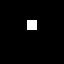

64 64 1



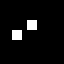

64 64 1



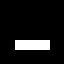

64 64 2



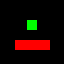

64 64 2



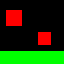

In [ ]:
#@title Dataset Obstacles { vertical-output: true}
def getFallingSquareDSStop():
  dataset = []
  for i in range(60):
    base = np.zeros((1,64,64,1))
    length = 10
    idx , idy = 20,27
    idx += min(i,10)
    base[:,idx:idx+length,idy:idy+length] = np.ones(1)
    dataset.append(base)
  return dataset

def getFalling2SquareDSStop():
  dataset = []
  for i in range(60):
    base = np.zeros((1,64,64,1))
    length = 10
    idx , idy = 20,27
    idx += min(i,10)
    base[:,idx:idx+length,idy:idy+length] = np.ones(1)
    base[:,30:30+length,idy-15:idy-15+length] = np.ones(1)
    dataset.append(base)
  return dataset


def getObstacleDSStop():
  dataset = []
  for i in range(60):
    base = np.zeros((1,64,64,1))
    idx , idy = 30,15
    idx += 10
    base[:,idx:idx+10,idy:idy+35] = np.ones(1)
    dataset.append(base)
  return dataset

def getCombineObsDS(obstacle , material):
  dataset = []
  for i in range(60):
    frame = np.concatenate((obstacle[i],material[i]), axis = -1)
    dataset.append(frame)
  return dataset

urlPrefix = 'https://raw.githubusercontent.com/andrinr/dlca-simulation/main/data/export2/'
#@title Dataset { vertical-output: true}

def getSoftBodies():
  dataset = []
  for i in range(100):
    filename = f'frame_{i:05d}.png'
    r = requests.get(urlPrefix+filename, stream=True)
    img = tf.keras.preprocessing.image.load_img(BytesIO(r.content), color_mode='rgb', target_size=(64, 64))
    img = np.array(img)
    img = tf.expand_dims(img, 0) / 255
    dataset.append(img.numpy()[:,:,:,:2])

    dataset.append(img.numpy()[:,:,:,:2])
  return dataset


dsSquareFallStop = getFallingSquareDSStop()
toGif(datasetToFrames(dsSquareFallStop))

ds2SquareFallStop = getFalling2SquareDSStop()
toGif(datasetToFrames(ds2SquareFallStop))

dsObstacleDSStop = getObstacleDSStop()
toGif(datasetToFrames(dsObstacleDSStop))

dsCombineObsDS = getCombineObsDS(dsObstacleDSStop ,dsSquareFallStop )
toGif(datasetToFrames(dsCombineObsDS))

dsSoftBodies = getSoftBodies()
toGif(datasetToFrames(dsSoftBodies))



In [ ]:
#@title Model { vertical-output: true}
class NNA(tf.keras.Model):

    def __init__(self, n_channels):
        super().__init__()
        self.channel_n = n_channels
        self.alpha = alpha

        self.dmodel = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 1, activation=tf.nn.relu),
            tf.keras.layers.Conv2D(self.channel_n, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        self(tf.zeros([1, 3, 3, n_channels]))

    def perceive(self, x):
        cellID = tf.constant([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]], dtype=tf.float32)
        sobelX = tf.constant([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=tf.float32)
        sobelY = tf.constant([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=tf.float32)

        kernel = tf.stack([cellID, sobelX, sobelY], -1)[:, :, None, :]
        kernel = tf.repeat(kernel, self.channel_n, 2)

        y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
        return y

    def call(self, x, steps = 1 ,  mask_chan = 2 ,  mask = False):
        if mask:
          pre_live_mask = get_living_mask(x , mask_chan)

        y = self.perceive(x)
        dx = self.dmodel(y) * steps

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= 0.5
        x += dx * tf.cast(update_mask, tf.float32)

        if mask:
          post_life_mask = get_living_mask(x , mask_chan)
          life_mask = pre_live_mask | post_life_mask
          life_mask = mask_edges(life_mask)
          return x * tf.cast(life_mask, tf.float32)

        return x

n_channels = 2 + 3
model = NNA(n_channels)
model.summary()

Model: "nna_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (1, 3, 3, 5)              2693      
                                                                 
Total params: 2,693
Trainable params: 2,693
Non-trainable params: 0
_________________________________________________________________


Epoch 0 , Loss 13.427734375



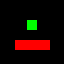
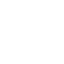

KeyboardInterrupt: ignored

In [ ]:
n_hidden_channels = 3
n_channels = 2
model = NNA(n_channels + n_hidden_channels)
dataset = getCombineObsDS(dsObstacleDSStop ,dsSquareFallStop )
start_frame = 0
init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,64,64,n_hidden_channels))) , axis = -1))

#@title multi-step + masking + 1 squares { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    loss = 0
    extra_step = 10
    x = init
    with tf.GradientTape() as g:        
        for i in tf.range(start_frame, 10):
              for j in range(extra_step):
                  x = model(x , mask=True)
              loss += loss_object(rg_m(dataset[i+1]), rg_m(x)) * 100
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init , 500 ,channels=2, mask=True)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

In [ ]:
model = NNA(5)
dataset = getCombineObsDS(dsObstacleDSStop ,ds2SquareFallStop )
start_frame = 0
init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,64,64,hidden_channels))) , axis = -1))

#@title multi-step + masking + 2 squares { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    loss = 0
    extra_step = 10
    x = init
    with tf.GradientTape() as g:        
        for i in tf.range(start_frame, 10):
              for j in range(extra_step):
                  x = model(x , mask=True)
              loss += loss_object(rg_m(dataset[i+1]), rg_m(x)) * 100
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init , 500 ,channels=2, mask=True)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title Model { vertical-output: true}
class NNA(tf.keras.Model):

    def __init__(self, n_channels):
        super().__init__()
        self.channel_n = n_channels
        self.alpha = alpha

        self.dmodel = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 4, activation=tf.nn.relu),
            tf.keras.layers.Conv2D(self.channel_n, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        self(tf.zeros([1, 3, 3, n_channels]))

    def perceive(self, x):
        cellID = tf.constant([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]], dtype=tf.float32)
        sobelX = tf.constant([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=tf.float32)
        sobelY = tf.constant([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=tf.float32)
        gauss = tf.

        kernel = tf.stack([cellID, sobelX, sobelY], -1)[:, :, None, :]
        kernel = tf.repeat(kernel, self.channel_n, 2)

        y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
        return y

    def call(self, x, steps = 1 ,  mask_chan = 2 ,  mask = False):
        if mask:
          pre_live_mask = get_living_mask(x , mask_chan)

        y = self.perceive(x)
        dx = self.dmodel(y) * steps

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= 0.5
        x += dx * tf.cast(update_mask, tf.float32)

        if mask:
          post_life_mask = get_living_mask(x , mask_chan)
          life_mask = pre_live_mask | post_life_mask
          life_mask = mask_edges(life_mask)
          return x * tf.cast(life_mask, tf.float32)

        return x

n_channels = 2 + 3
model = NNA(n_channels)
model.summary()

Model: "nna_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (1, 3, 3, 5)              2693      
                                                                 
Total params: 2,693
Trainable params: 2,693
Non-trainable params: 0
_________________________________________________________________


Epoch 0 , Loss 9.3603515625



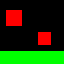
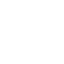

KeyboardInterrupt: ignored

In [ ]:
dataset = dsSoftBodies
start_frame = 0

end_frame = 100
extra_steps = 10
max_frame_steps = 80
n_channels = 2
n_hidden_channels = 6
model = NNA(n_channels + n_hidden_channels)
init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,64,64,n_hidden_channels))) , axis = -1))

#@title multi-step + masking + 2 squares { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    loss = 0
    extra_step = 10
    x = init
    frame_steps = tf.random.uniform([],1,max_frame_steps,tf.int32)
    loss = 0
    random_frame_idx = np.random.randint(start_frame,end_frame-max_frame_steps)
    x = tf.convert_to_tensor(np.concatenate((dataset[random_frame_idx],np.ones((1,64,64,n_hidden_channels))) , axis = -1))
    with tf.GradientTape() as g:        
        for i in tf.range(frame_steps):
          for j in tf.range(extra_steps):
              x = model(x , mask= True)
          loss += loss_object(rg_m(dataset[random_frame_idx+frame_steps]), rg_m(x))

    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init , 500 ,channels=2, mask=True)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()